<a href="https://colab.research.google.com/github/mdemirk1/Face-Mask-Recognition-using-OpenCV-and-AI/blob/main/MS_project_last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# face mask detection using opencv library.

In [ ]:
# import related libraries.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import glob

In [ ]:
# So, to create this classifier, we need data in the form of images.
# I collected a dataset containing images of masked and unmasked faces from Kaggle as suggested by the professor.

In [ ]:
# To properly train the model, since the images we have is limited in number, I will
# validate against a trained network called Mobilenetv2, trained on the Imagenet dataset.
# More details will be provided.

In [ ]:
imagePaths = list(paths.list_images('/content/drive/MyDrive/Colab Notebooks/term_project'))
data = []
labels = []
# iterate over directory
for imagePath in imagePaths:
	# extract the class label from the filename (with_mask, without_mask)
	label = imagePath.split(os.path.sep)[-2]
	# load the input image
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists
	data.append(image)
	labels.append(label)
# convert the data and labels to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# The next step is to load the pre-trained model and adapt it to our problem.
# So we just remove the top layers of this pre-trained model and add some layers of our own.
# This is called transfer learning.

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
# construct the head of the model that will be placed on top of the the base model.
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# this is the actual model that I will train.
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Now we need to convert labels to one-hot encoding.
# After that we split the data into training set and test set for evaluation.
# Also, the next step is data augmentation, which significantly increases the variety of available data
# we train the model without actually collecting new data.

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing
# splits using 80% and 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# compile the model and train it on the augmented data.

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)

model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
36/36 [==============================] - 105s 3s/step - loss: 0.5746 - accuracy: 0.7296 - val_loss: 0.2399 - val_accuracy: 0.9932
Epoch 2/20
36/36 [==============================] - 90s 2s/step - loss: 0.2184 - accuracy: 0.9688 - val_loss: 0.0993 - val_accuracy: 0.9932
Epoch 3/20
36/36 [==============================] - 86s 2s/step - loss: 0.1159 - accuracy: 0.9842 - val_loss: 0.0586 - val_accuracy: 0.9932
Epoch 4/20
36/36 [==============================] - 94s 3s/step - loss: 0.0698 - accuracy: 0.9895 - val_loss: 0.0431 - val_accuracy: 0.9932
Epoch 5/20
36/36 [==============================] - 92s 3s/step - loss: 0.0603 - accuracy: 0.9895 - val_loss: 0.0360 - val_accuracy: 0.9932
Epoch 6/20
36/36 [==============================] - 78s 2s/step - loss: 0.0489 - accuracy: 0.9895 - val_loss: 0.0322 - val_accuracy: 0.9932
Epoch 7/20
36/36 [==============================] - 91s 3s/step - loss: 0.0411 - accuracy: 0.9930 - val_loss:

<ipython-input-12-5fa71f81a76a>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


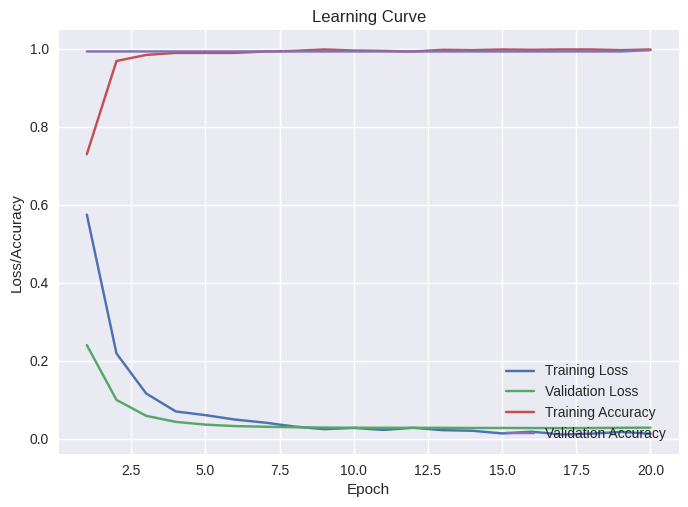

In [ ]:
# plot a graph to see the learning curve.
N = EPOCHS
plt.style.use("seaborn")
plt.figure()
epochs = range(1, N + 1)
plt.plot(epochs, H.history["loss"], label="Training Loss")
plt.plot(epochs, H.history["val_loss"], label="Validation Loss")
plt.plot(epochs, H.history["accuracy"], label="Training Accuracy")
plt.plot(epochs, H.history["val_accuracy"], label="Validation Accuracy")
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# To save the trained model
model.save('/content/drive/MyDrive/Colab Notebooks/term_project/face_mask_detection_model_trainedby_dora.h5')

In [ ]:
# With the trained model, I will define a function that detects if the
# person in the image wears a face mask or not, using haarcascade_frontalface_alt2.xml file
# which has been provided by opencv library. It is is a pre-trained Haar cascade classifier
# XML file used for face detection in computer vision applications.

In [ ]:
# load necessary models
faceCascade = cv2.CascadeClassifier("/content/drive/MyDrive/Colab Notebooks/haarcascade_frontalface_alt2.xml")
model = load_model('/content/drive/MyDrive/Colab Notebooks/term_project/face_mask_detection_model_trainedby_dora.h5')

In [ ]:
def detect_mask(frame):
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  if gray is None:
        # Handle case when the image cannot be loaded
        print("Error: Failed to load the image")
        return frame  # Return the original frame

  faces = faceCascade.detectMultiScale(gray,
                                        scaleFactor=1.1,
                                        minNeighbors=5,
                                        minSize=(60, 60),
                                        flags=cv2.CASCADE_SCALE_IMAGE)
  faces_list=[]
  preds=[]
  for (x, y, w, h) in faces:
      face_frame = frame[y:y+h,x:x+w]
      face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
      face_frame = cv2.resize(face_frame, (224, 224))
      face_frame = img_to_array(face_frame)
      face_frame = np.expand_dims(face_frame, axis=0)
      face_frame =  preprocess_input(face_frame)
      faces_list.append(face_frame)
      if len(faces_list)>0:
          preds = model.predict(faces_list)
      for pred in preds:
          (mask, without_mask) = pred
      label = "Mask" if mask > without_mask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      label = "{}: {:.2f}%".format(label, max(mask, without_mask) * 100)
      cv2.putText(frame, label, (x, y- 10),
                  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

      cv2.rectangle(frame, (x, y), (x + w, y + h),color, 3)

  return frame

1/1 [==============================] - 0s 90ms/step


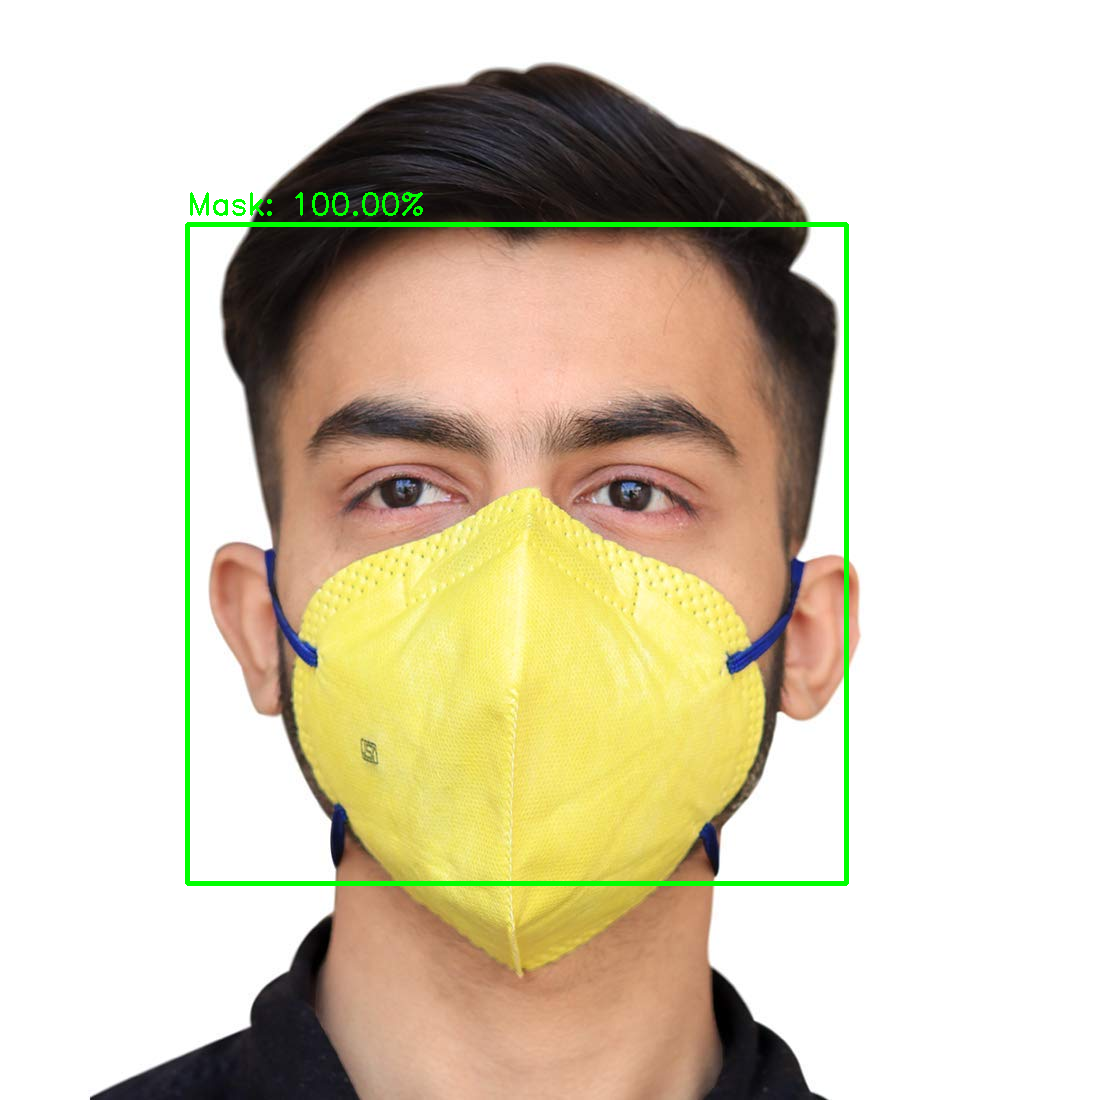

In [ ]:
img1 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/term_project/sample_images/yell1.jpg")

out = detect_mask(img1)
cv2_imshow(out)

1/1 [==============================] - 0s 93ms/step


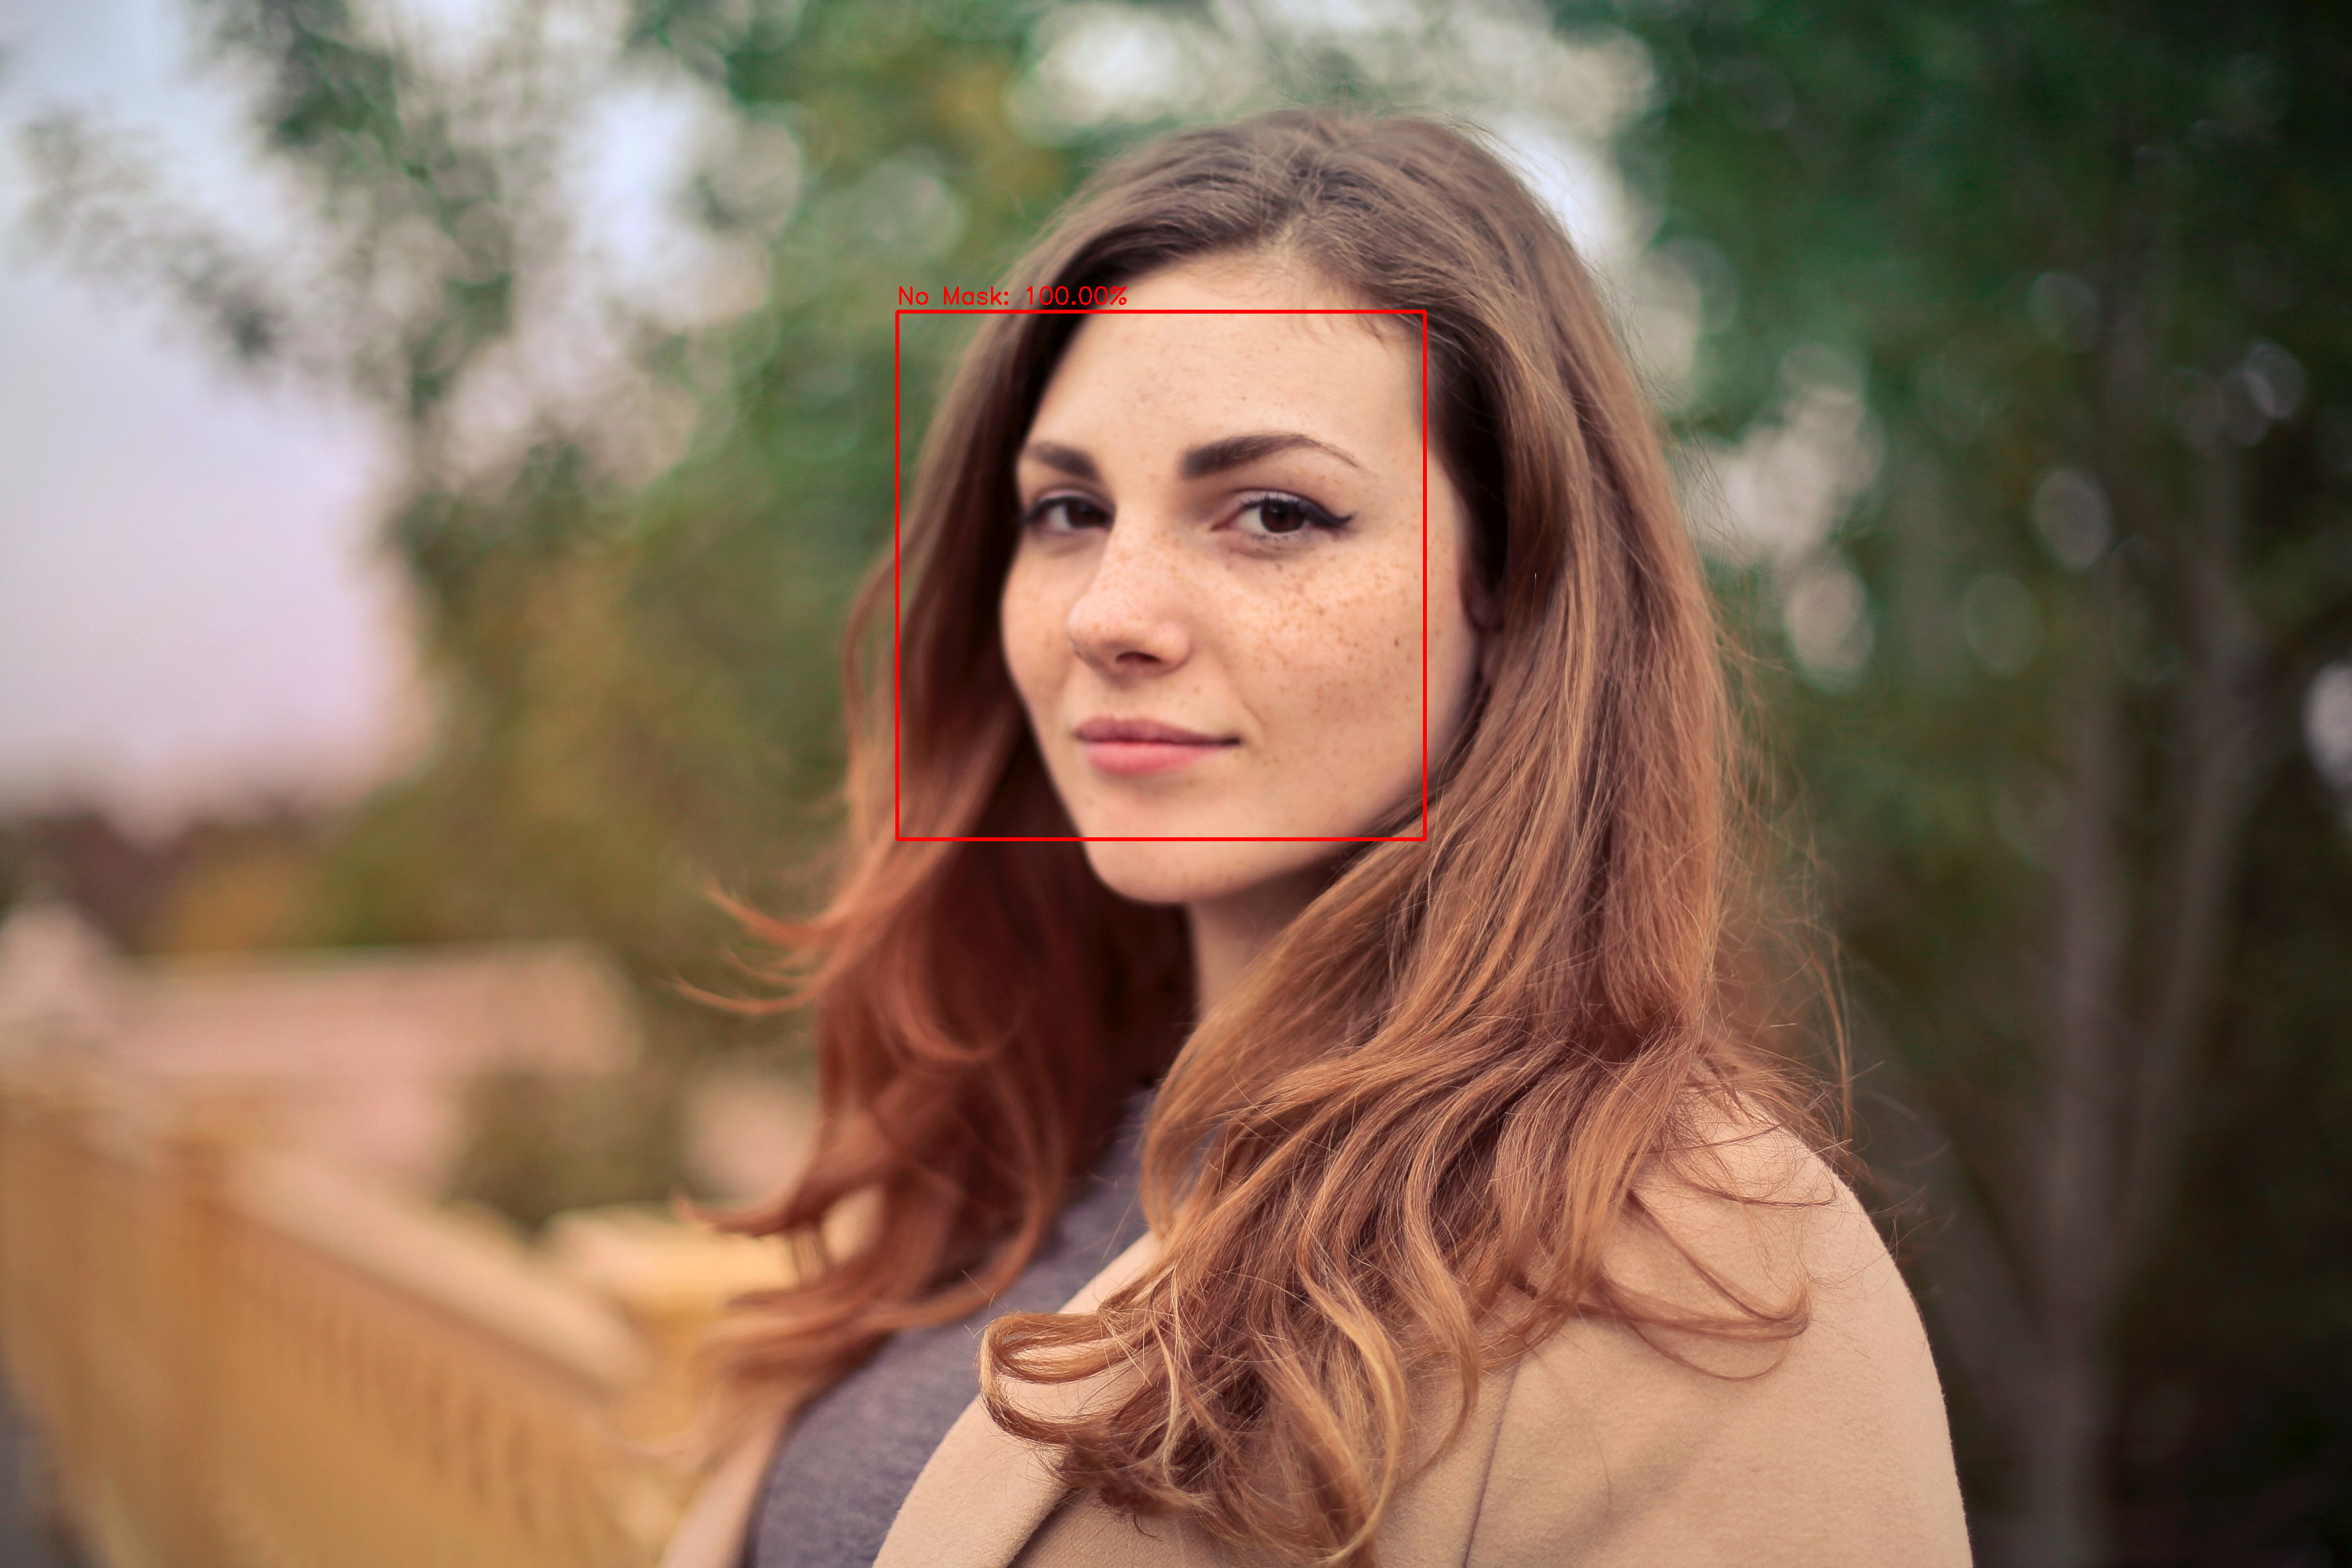

In [ ]:
img3 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/term_project/sample_images/pexels-andrea-piacquadio-733872.jpg")

out = detect_mask(img3)
cv2_imshow(out)

1/1 [==============================] - 0s 101ms/step


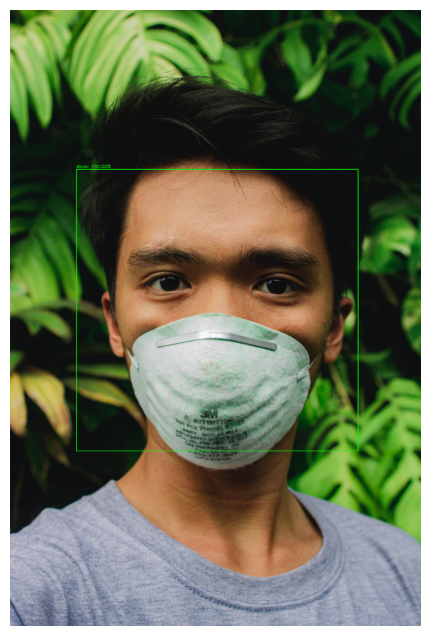

In [ ]:
# tried to resize it to a smaller image here.
img4 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/term_project/sample_images/pexels-nothing-ahead-3571628.jpg")

output = detect_mask(img4)
output_resized = cv2.resize(output, (1000, 1500))

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output_resized, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

